## Set-up

In [80]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px

import numpy as np
from tqdm.notebook import trange

sns.set_theme()
colors = sns.color_palette("deep")

from utils import geometric_median, geometric_medoid, month_to_season, plot_components
from NMF_iter import normalize_curves, functional_norm
from itertools import permutations, product

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

'it_IT'

In [47]:
def align_components(H_results, W_results, A, ref_idx=0):
    # Align the components
    n_comp, n_eval_points, n_runs = H_results.shape
    ref_H = H_results[..., ref_idx]

    for n in range(1, n_runs):

        best_permutation = list(range(n_comp))
        eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
        best_alignment = np.linalg.norm(ref_H - H_results[..., n][range(n_comp), :], 'fro')

        sources_groups = [np.nonzero(A[:, i])[0] for i in range(A.shape[1])]
        valid_permutations = product(*[permutations(a) for a in sources_groups])
        valid_permutations = [[item for subtuple in permutation for item in subtuple] for permutation in valid_permutations]
        for permutation in valid_permutations:
            alignment = np.linalg.norm(ref_H - H_results[..., n][list(permutation)[:n_comp], :], 'fro')

            if alignment < best_alignment:
                best_alignment = alignment
                best_permutation = list(permutation)

        H_results[..., n] = H_results[..., n][best_permutation, :]
        W_results[..., n] = W_results[..., n][:, best_permutation]

In [115]:
n_components = 5 # Number of components for the matrix factorization
n_runs = 1000
smoothed = False
specific = '_Italy'

start_year = 2020
end_year = 2022

colormap = ListedColormap([colors[k] for k in range(n_components)])

region_order = [
    'North',
    'Centre.North',
    'Sardinia',
    'Centre.South',
    'South',
    'Calabria',
    'Sicily'
]

daytype_order = [
    'Monday',
    'Working day',
    'Saturday',
    'Holiday'
]

# Process data

## Data matrix $X$

In [116]:
if smoothed:
    infile = 'data/daily_curves_pos_smoothed_13b_15min.csv'
else:
    infile = f'data/2_processed/daily_curves{specific}.csv'
input_df = pd.read_csv(infile, index_col=0)
print(len(input_df))
input_df.head(3)

2191


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
2018-01-01_Holiday,24743.000,23797.000,22175.999,21042.000,20146.999,20079.000,20942.001,21712.000,21969.999,22967.000,...,26643.000,26807.000,29947.001,31103.000,31537.000,30804.001,29621.000,27749.000,25388.000,22714.001
2018-01-02_Working day,22714.001,20794.001,19802.002,19573.002,19679.000,20891.000,24197.999,28537.000,32988.000,37794.999,...,36511.999,37393.000,41395.000,42362.001,42081.001,39555.000,37163.000,33313.000,29811.000,26314.001
2018-01-03_Working day,26314.001,24248.999,22927.999,22537.999,22314.001,23529.001,27206.000,32970.999,37419.000,40908.999,...,40106.999,40662.001,44557.000,44708.000,43818.999,41347.000,38572.999,34229.001,30436.999,27199.000


In [117]:
unit_info = input_df.index.str.extract(r'^(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
df = df[(df.year.astype(int) >= start_year) & (df.year.astype(int) <= end_year)]
print(len(df))
df.head(3)

1096


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,year,month,daytype
2020-01-01_Holiday,24300.000,23308.000,22157.999,20786.000,19891.000,19947.001,20578.999,21473.999,21413.001,22792.0,...,29663.000,30459.000,30347.000,29180.0,27406.000,24879.000,22212.999,2020,01,Holiday
2020-01-02_Working day,22212.999,20395.000,19276.000,19059.001,19167.999,20177.000,23560.000,28026.999,31600.000,35583.0,...,40361.000,40117.000,38273.000,35756.0,32371.000,28863.001,25324.000,2020,01,Working day
2020-01-03_Working day,25324.000,23275.001,21741.000,21228.999,21438.000,22064.999,25270.000,30257.000,34130.000,37619.0,...,41079.001,40668.001,38369.999,35184.0,31951.999,28347.001,25134.999,2020,01,Working day


In [118]:
X = df.drop(unit_info.columns, axis=1)
X = normalize_curves(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
2020-01-01_Holiday,0.040982,0.039309,0.037369,0.035055,0.033546,0.033640,0.034706,0.036216,0.036113,0.038439,...,0.041075,0.041277,0.047119,0.050026,0.051369,0.051180,0.049212,0.046220,0.041958,0.037462
2020-01-02_Working day,0.029836,0.027394,0.025891,0.025600,0.025746,0.027102,0.031646,0.037646,0.042445,0.047795,...,0.046833,0.047789,0.053384,0.054212,0.053885,0.051408,0.048027,0.043480,0.038768,0.034015
2020-01-03_Working day,0.032524,0.029893,0.027922,0.027265,0.027533,0.028339,0.032455,0.038860,0.043834,0.048315,...,0.046408,0.047624,0.052403,0.052759,0.052231,0.049279,0.045187,0.041037,0.036407,0.032281
2020-01-04_Saturday,0.035505,0.032732,0.031074,0.030431,0.030038,0.031102,0.033951,0.038281,0.041585,0.045738,...,0.043068,0.043740,0.049297,0.051954,0.053135,0.051134,0.046995,0.043196,0.039101,0.034850
2020-01-05_Holiday,0.038522,0.034876,0.032662,0.031490,0.031316,0.031853,0.033533,0.036586,0.037979,0.041645,...,0.041873,0.042782,0.047938,0.051710,0.053156,0.051982,0.048822,0.045577,0.041847,0.037617


## NMF

In [119]:
p = len(X.columns)

In [120]:
# Load the arrays from the .npz file
if smoothed:
    path = f'data/3_output/nmf_results/batch/{n_components}comp_smoothed_{n_runs}runs{specific}.npz'
else:  
    path = f'data/3_output/nmf_results/batch/{n_components}comp_{n_runs}runs_PenNMF_lambda_eq.npz'
data = np.load(path)
print('Loaded ', path)

Loaded  data/3_output/nmf_results/batch/5comp_1000runs_PenNMF_lambda_eq.npz


In [121]:
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
loss_nmf = data['loss_nmf']
loss_constraint = data['loss_constraint']

In [122]:
pd.Series(iterations).quantile(np.linspace(0,1,11))

0.0    1330.0
0.1    1570.0
0.2    1658.0
0.3    1740.0
0.4    1820.0
0.5    1930.0
0.6    2090.0
0.7    2416.0
0.8    2960.0
0.9    3451.0
1.0    5330.0
dtype: float64

In [123]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
H_results = H_results[..., iterations > 100]
W_results = W_results[..., iterations > 100]
iterations = iterations[iterations > 100]
loss_nmf = loss_nmf[iterations > 100]
loss_constraint = loss_constraint[iterations > 100]
print('{} results clean'.format(W_results.shape[2]))

1000 results clean


In [124]:
# Align solutions to have comp x of solution i matching comp x of solution j
A = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1]
])
align_components(H_results, W_results, A, ref_idx=0)

In [125]:
n_clean_runs = W_results.shape[2]
abscissa = [float(x) for x in X.columns]

## Quick data check

Check-plots on the solutions found

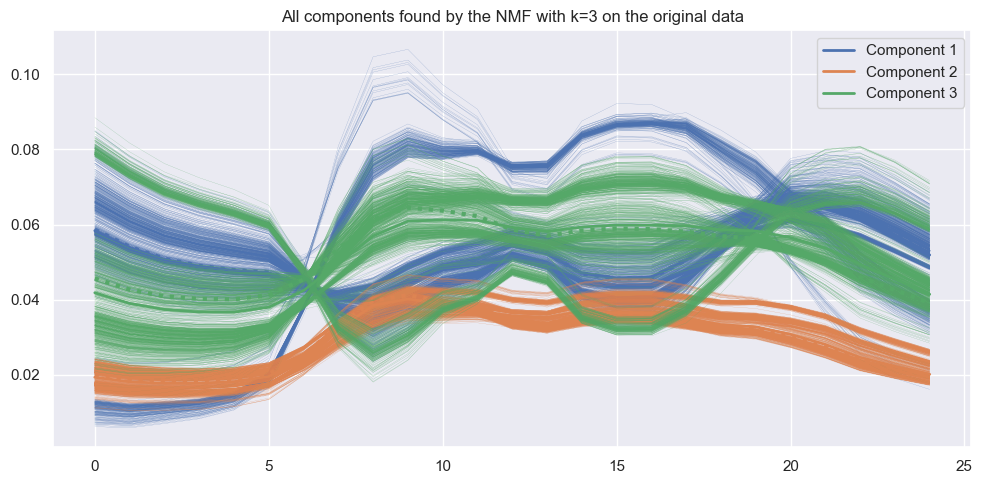

In [94]:
fig, ax = plt.subplots(figsize=(10, 5))

for k in range(n_components):
    for i in range(n_clean_runs):
        line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[k])
    label = f'Component {k + 1}'
    ax.plot(abscissa, geometric_median(H_results[k, ...].T), linewidth=2, color=colors[k], label=label)
    ax.plot(abscissa, geometric_medoid(H_results[k, ...].T), linewidth=3, linestyle='dotted', color=colors[k])
ax.set_title(f"All components found by the NMF with k={n_components} on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
ax.legend()
plt.tight_layout()

Let's plot separately per component

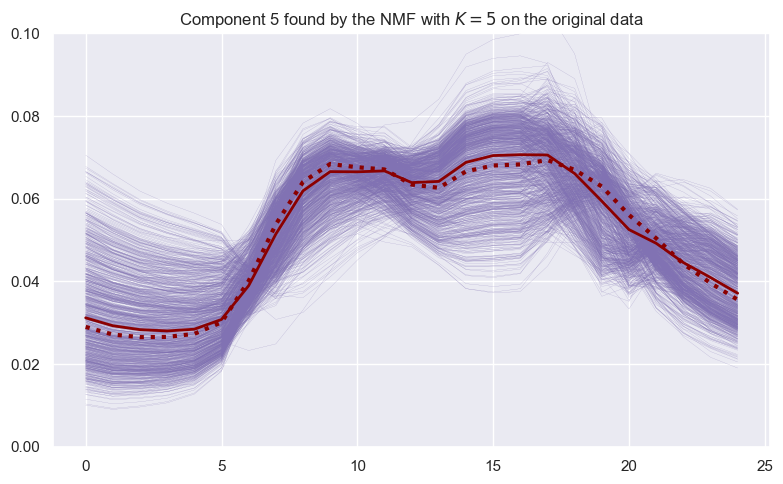

In [132]:
k = 4
fig, ax = plt.subplots(figsize=(8, 5))
for i in range(n_clean_runs):
    line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[k])
ax.plot(abscissa, geometric_median(H_results[k, ...].T), linewidth=2, color='darkred')
ax.plot(abscissa, geometric_medoid(H_results[k, ...].T), linewidth=3, linestyle='dotted', color='darkred')
ax.set_title(f"Component {k + 1} found by the NMF with $K={n_components}$ on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
plt.ylim((0, 0.1))
plt.tight_layout()

<Axes: >

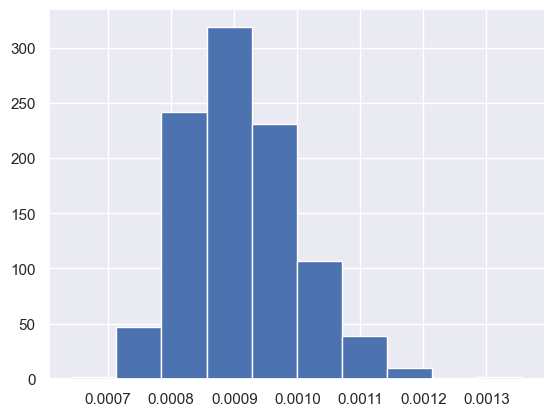

In [133]:
pd.Series(loss_constraint).hist()

<Axes: >

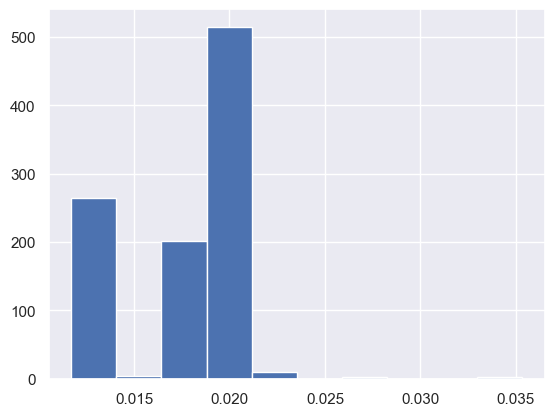

In [134]:
pd.Series(loss_nmf).hist()

# Selection of the optimal solution

## Based on modelling constraints

### Cyclic profiles

We want to find solutions for which
$$\text{discontinuity}(H) = \sum_{k=1}^K(H_k(p) - H_k(1))^2$$

In [135]:
H_discontinuity = ((H_results[:, 0, :] - H_results[:, p-1, :])**2).sum(axis=0)

<Axes: >

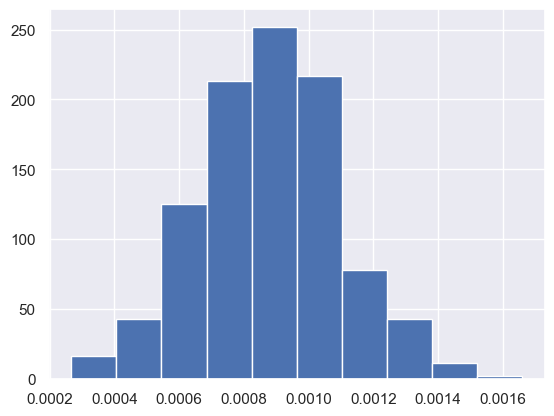

In [136]:
pd.Series(H_discontinuity).hist()

### Total distance of concentration vectors to simplex

The distance to the simplex of one observation $x$ to the simplex $\mathcal{S}(n)$ is the following
$$\text{dist}(x, \mathcal{S}(n)) = \inf_{\substack{y \in \mathcal{S}(n)}} d(x, y)$$

The point $y$ minimizing the distance is:
$$y = \frac{x}{||x||_1}$$

Here we will compute the sum of the distances to the simplex for all vector of concentrations of the matrix $W$

In [137]:
W_proj_simplex = W_results / W_results.sum(axis=1)[:, np.newaxis, :]
W_dist_simplex = np.sqrt(((W_results - W_proj_simplex)**2).sum(axis=1))
W_sum_dist_simplex = W_dist_simplex.sum(axis=0)

<Axes: >

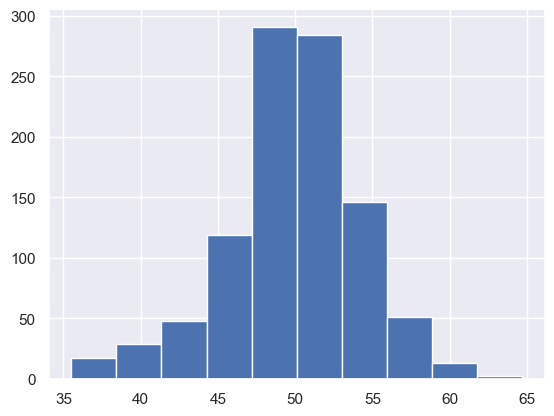

In [138]:
pd.Series(W_sum_dist_simplex).hist()

### Total distance of the components to the p-dimensional simplex

Similarly, the unit l1 norm constraint on the components, having necessarily positive coordinates, result in the components having to lie on the unit 1-sphere

In [139]:
H_proj_unit = np.empty_like(H_results)
for n in range(H_results.shape[2]):
    H_proj_unit[..., n] = normalize_curves(H_results[..., n])
H_dist_unit = np.sqrt(((H_results - H_proj_unit)**2).sum(axis=1))
H_sum_dist_unit = H_dist_unit.sum(axis=0)

<Axes: >

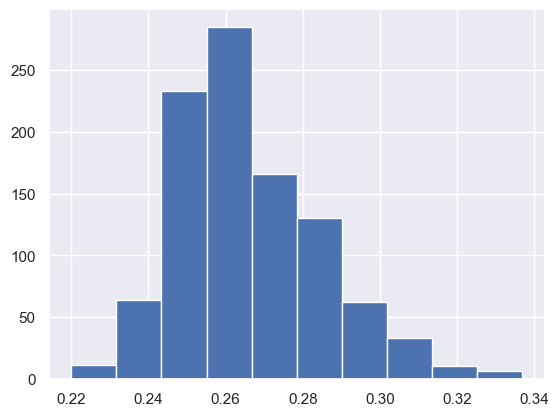

In [140]:
pd.Series(H_sum_dist_unit).hist()

In [141]:
criteria_df = pd.DataFrame({
    'dist_simplex': W_sum_dist_simplex,
    'loss_nmf': loss_nmf,
    'loss_constraint': loss_constraint,
})
criteria_df

,dist_simplex,loss_nmf,loss_constraint
0,52.126953,0.017396,0.000775
1,56.713254,0.017833,0.000840
2,49.301684,0.020213,0.000997
3,53.524345,0.020686,0.001008
4,49.375335,0.019309,0.000902
...,...,...,...
995,47.255336,0.018684,0.000884
996,49.713259,0.019611,0.000960
997,48.334237,0.013918,0.000856
998,47.661621,0.019466,0.000913


In [142]:
dimensions = criteria_df.columns
height, width = 1000, 1000

fig = px.scatter_matrix(criteria_df, dimensions=dimensions, hover_name=criteria_df.index)
fig.update_layout(height=height, width=width)
fig.update_traces(selected=dict(marker=dict(color='red')))
fig.show()

## Optimal solution

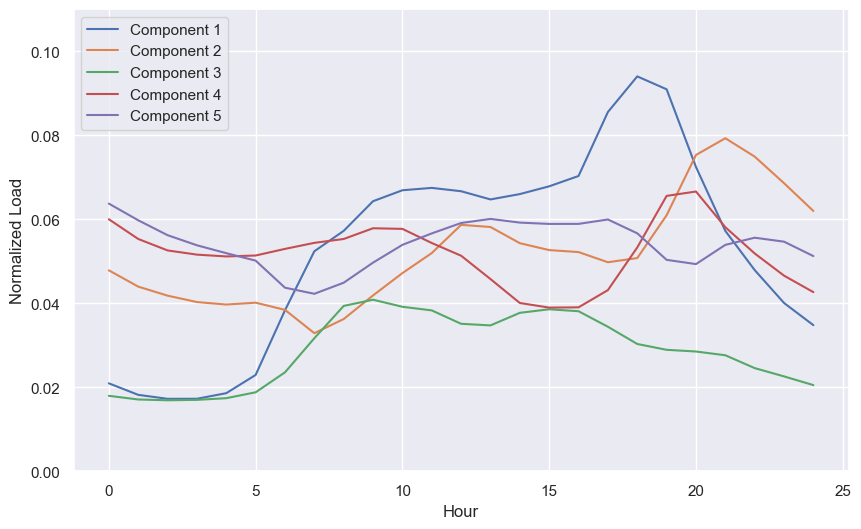

In [165]:
best_run = 810

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.11))

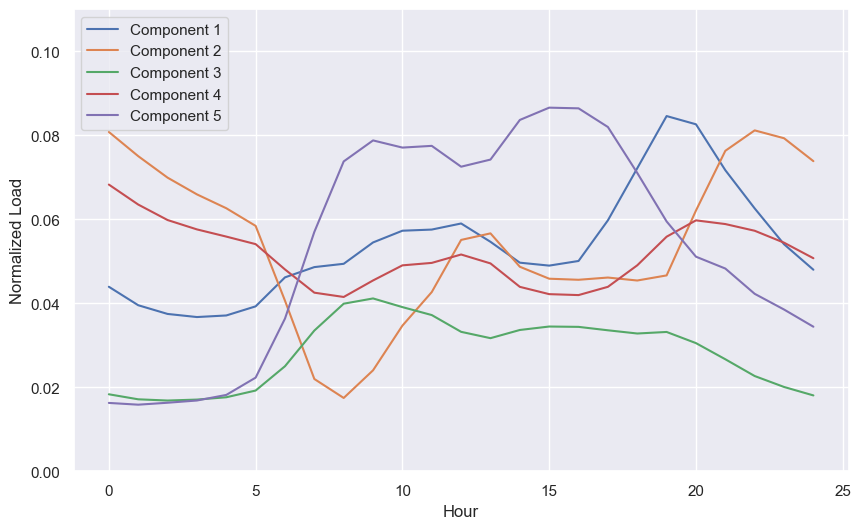

In [144]:
# Other alternative solution
best_run = 384

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.11))

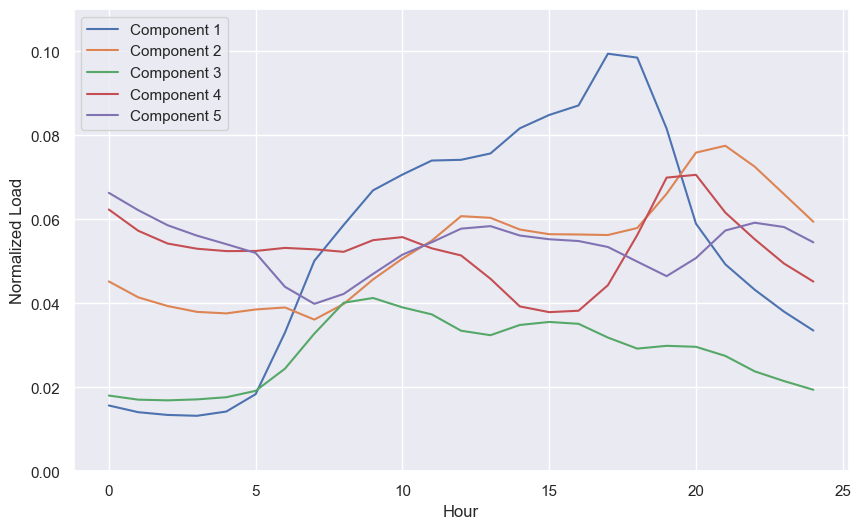

In [147]:
# Other alternative solution
best_run = 963

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.11))

# Analysis of the solution

In [158]:
W = pd.DataFrame(W, index=df.index, columns=[f"Component {k+1}" for k in range(n_components)])
W[unit_info.columns] = df[unit_info.columns]
W['season'] = W.month.astype(int).map(month_to_season)
W

,Component 1,Component 2,Component 3,Component 4,Component 5,year,month,daytype,season
2020-01-01_Holiday,0.125257,0.183061,0.000359,0.206175,0.272552,2020,01,Holiday,Winter
2020-01-02_Working day,0.309052,0.140156,0.225258,0.100476,0.110664,2020,01,Working day,Winter
2020-01-03_Working day,0.272628,0.039871,0.270941,0.141336,0.179540,2020,01,Working day,Winter
2020-01-04_Saturday,0.244161,0.094270,0.071211,0.241674,0.166686,2020,01,Saturday,Winter
2020-01-05_Holiday,0.199868,0.182585,0.009582,0.203062,0.197350,2020,01,Holiday,Winter
...,...,...,...,...,...,...,...,...,...
2022-12-27_Working day,0.238575,0.120008,0.377759,0.118380,0.099350,2022,12,Working day,Winter
2022-12-28_Working day,0.235238,0.095144,0.360968,0.140615,0.114634,2022,12,Working day,Winter
2022-12-29_Working day,0.235564,0.060705,0.280929,0.180572,0.151826,2022,12,Working day,Winter
2022-12-30_Working day,0.218589,0.097439,0.287803,0.173996,0.137011,2022,12,Working day,Winter


In [159]:
W.melt(id_vars=unit_info.columns.to_list()+['season'], var_name='component', value_name='concentration')

,year,month,daytype,season,component,concentration
0,2020,01,Holiday,Winter,Component 1,0.125257
1,2020,01,Working day,Winter,Component 1,0.309052
2,2020,01,Working day,Winter,Component 1,0.272628
3,2020,01,Saturday,Winter,Component 1,0.244161
4,2020,01,Holiday,Winter,Component 1,0.199868
...,...,...,...,...,...,...
5475,2022,12,Working day,Winter,Component 5,0.099350
5476,2022,12,Working day,Winter,Component 5,0.114634
5477,2022,12,Working day,Winter,Component 5,0.151826
5478,2022,12,Working day,Winter,Component 5,0.137011


<Axes: xlabel='component', ylabel='concentration'>

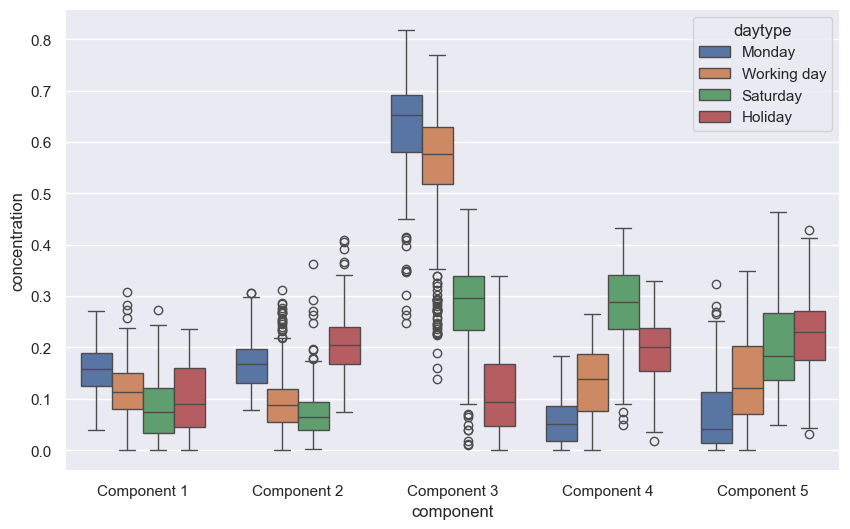

In [160]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list()+['season'], var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='daytype',
    hue_order=daytype_order
)

<Axes: xlabel='month', ylabel='concentration'>

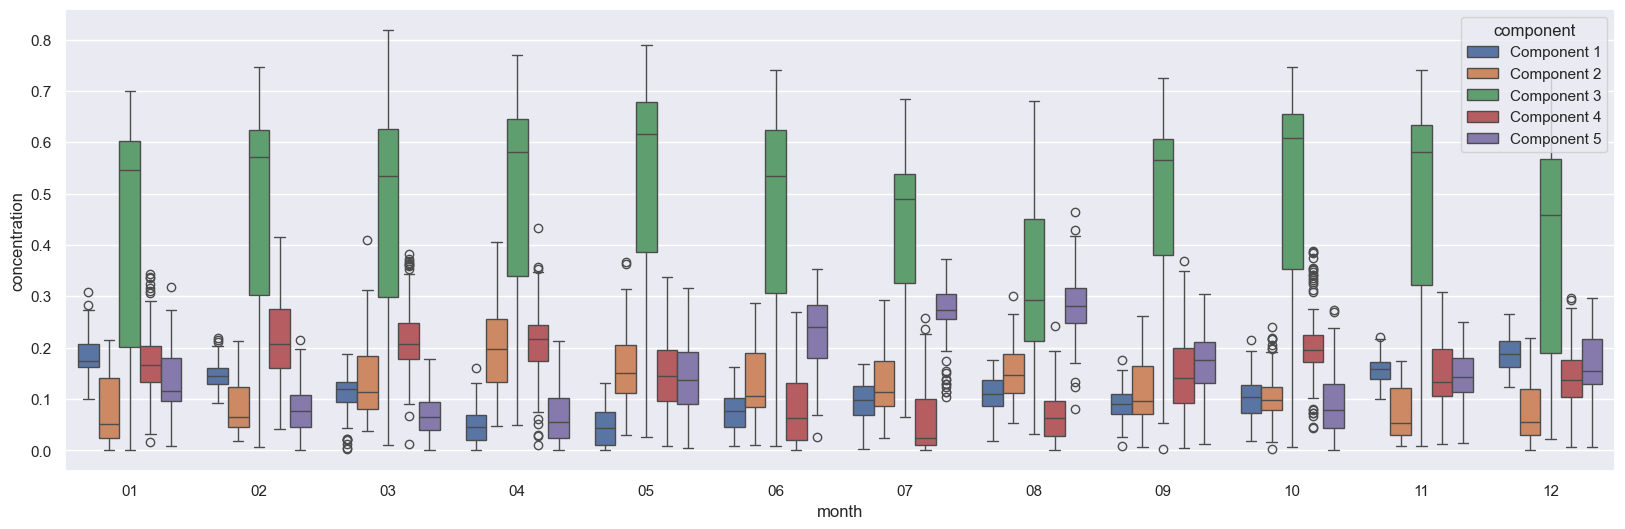

In [161]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list()+['season'], var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

<Axes: xlabel='month', ylabel='concentration'>

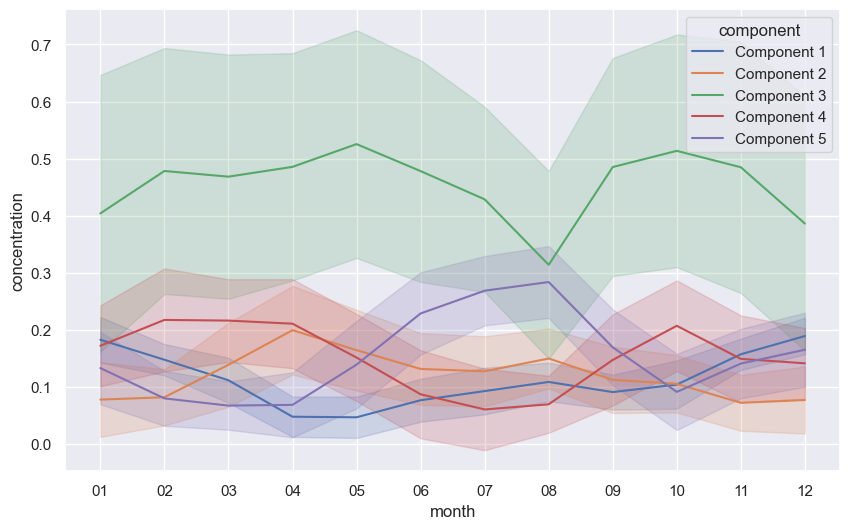

In [162]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=W.melt(id_vars=unit_info.columns.to_list()+['season'], var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

In [163]:
dimensions = [f'Component {k+1}' for k in range(n_components)]
height, width = 1000, 1100

fig = px.scatter_matrix(W, dimensions=dimensions, hover_name=W.index, color='daytype')
fig.update_layout(height=height, width=width)
fig.update_traces(selected=dict(marker=dict(color='yellow')))
fig.show()

In [164]:
dimensions = [f'Component {k+1}' for k in range(n_components)]
height, width = 1000, 1100

fig = px.scatter_matrix(W, dimensions=dimensions, hover_name=W.index, color='season')
fig.update_layout(height=height, width=width)
fig.update_traces(selected=dict(marker=dict(color='yellow')))
fig.show()

## Save results

In [166]:
opt = 'PenNMF'
if smoothed:
    outfile = f'data/3_output/nmf_results/WHopt{opt}_{n_components}comp_smoothed_{n_runs}runs.npz'
else:
    outfile = f'data/3_output/nmf_results/WHopt{opt}_{n_components}comp_{n_runs}runs{specific}.npz'
np.savez(outfile, W=W, H=H)
print("Saved results at", outfile)

Saved results at data/3_output/nmf_results/WHoptPenNMF_5comp_1000runs_Italy.npz


___

# TESTS

In [ ]:
# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=dist_to_cons,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of squared distance of concentration vectors to the simplex',
    yaxis_title='Absolute distance to consumption data',
    title='Interaction between the criteria for mathematical and consumption solutions',
    height=800,
    width=1000,
    font=dict(
        size=16,  # Adjust font size here
    )
)

# # Show the plot
# fig.show()

In [139]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_sum_dist_unit,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Sum of distance to simplex for H',
    title='Compliance of solutions with physics of the system and approximation quality',
    height=800,
    width=1000
)


In [140]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=errors,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Sum of distance to simplex for H',
    title='Compliance of solutions with physics of the system and approximation quality',
    height=800,
    width=1000
)
